In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import copy
from sklearn.feature_selection import VarianceThreshold
from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
print(device)
print(torch.cuda.get_device_name(0))
print(torch.cuda.memory_summary())

cuda
NVIDIA GeForce RTX 4070 Laptop GPU
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool 

In [4]:
def get_SNP(data):   
    df = pd.read_csv(f"data/{data}")
    X = df.drop(["Phenotype", "Genotype"],axis=1) # All SNP columns
    y = df['Phenotype']  # Convert phenotype to float

    variances = X.var(axis=0)
    optimal_threshold = variances.quantile(0.25)
    var_thresh = VarianceThreshold(threshold=optimal_threshold) 
    X_var_filtered = pd.DataFrame(var_thresh.fit_transform(X), columns=X.columns[var_thresh.get_support()])
    n_features = X_var_filtered.shape[1]

    X_var_filtered = np.array(X_var_filtered)
    y = np.array(y)

    # Train-Test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(
        X_var_filtered, y, test_size=0.1)

    # Further split train into train/val (80/20 split of the train set)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.1)
    
    input_dim = X_train.shape[1]

    class SNPPhenotypeDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X, dtype=torch.float32)  
            self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)  

        def __len__(self):
            return len(self.X)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]
        
    train_dataset = SNPPhenotypeDataset(X_train, y_train)
    val_dataset   = SNPPhenotypeDataset(X_val, y_val)
    test_dataset  = SNPPhenotypeDataset(X_test, y_test)

    batch_size = 8

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader,input_dim


In [5]:
def createANNModel(hidden_units, drop,lr,decay,input_length,activation_type="relu",optimizer_type="adam"):
    class ANN(nn.Module):
        def __init__(self, hidden_units, drop, activation_type,input_length):
            super(ANN, self).__init__()

            self.nLayers = len(hidden_units)
            
            self.activations = {
                'relu': F.relu,              
                'leaky_relu': F.leaky_relu,  
                'elu': F.elu,
                "tanh": F.tanh        
            }

            self.activation = self.activations.get(activation_type.lower(), F.relu)

            self.layers = nn.ModuleDict()

            self.batch_norms = nn.ModuleDict()

            self.layers["input"] = nn.Linear(input_length, hidden_units[0])
            self.batch_norms["input"] = nn.BatchNorm1d(hidden_units[0])

            for i in range(self.nLayers - 1):
                self.layers[f"hidden{i}"] = nn.Linear(hidden_units[i], hidden_units[i+1])
                self.batch_norms[f"hidden{i}"] = nn.BatchNorm1d(hidden_units[i+1])
            
            self.layers["output"] = nn.Linear(hidden_units[-1], 1)

            self.dropout = nn.Dropout(p=drop)
            
        def forward(self,x):

            x = self.layers['input'](x)
            x = self.batch_norms["input"](x)
            x = self.activation(x)

            # hidden layers
            for i in range(self.nLayers - 1):
                x = self.layers[f'hidden{i}'](x)
                x = self.batch_norms[f'hidden{i}'](x)
                x = self.activation(x)
                x = self.dropout(x)

            # return output layer
            x = self.layers['output'](x)
            return x
    
    
    model = ANN(hidden_units,drop,activation_type,input_length)

    criterion = nn.MSELoss()

    optimizers = {
    'adam': lambda: torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay),
    'sgd': lambda: torch.optim.SGD(model.parameters(), lr=lr, weight_decay=decay, momentum=0.9),
    "adamw": lambda: torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=decay),
    "rmsprop": lambda: torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=decay, alpha=0.99,momentum=0.9),
    }
    optimizer = optimizers.get(optimizer_type.lower(), optimizers['adam'])()

    return model, criterion, optimizer

In [6]:

def trainAndEval(model,criterion,optimizer,train_loader,val_loader,max_epochs=1000,patience=500):
    best_val_loss = float("inf")
    train_losses = []
    val_losses = []
    model.to(device)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    for epoch in range(max_epochs):
        model.train()
        running_train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)  # Reshape y to match output

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * batch_X.size(0)

        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device).view(-1, 1)  # Reshape y to match output
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                running_val_loss += loss.item() * batch_X.size(0)

        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(epoch_val_loss)

        #print(f"Epoch [{epoch+1}/{max_epochs}] | Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")

        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            #print(f"Early stopping triggered after {epoch+1} epochs")
            print(f"Final Train loss: {train_losses[-1]:.4f} | Final Val Loss: {val_losses[-1]:.4f}")
            break

    # Load best model for evaluation
    if 'best_model_state' in locals():
        model.load_state_dict(best_model_state)
    
    return model

In [7]:
def grid_search_MLP(target_r2=0.7, data_folder="data"):
    # Create a DataFrame to store best results for each dataset
    best_results_df = pd.DataFrame(columns=[
        'Dataset', 'MSE', 'MAE', 'R2', 'Units', 'Dropout', 'Learning_Rate', 
        'Weight_Decay', 'Epochs', 'Activation', 'Optimizer', 'Patience'
    ])
    
    # Iterate through each dataset in the folder
    for data_file in os.listdir(data_folder):
        if not data_file.endswith('.csv'):
            continue
            
        print(f"\n\n{'='*50}")
        print(f"Processing dataset: {data_file}")
        print(f"{'='*50}")
        
        # Create a DataFrame to store all trial results for this dataset
        all_trials_df = pd.DataFrame(columns=[
            'Trial', 'MSE', 'MAE', 'R2', 'Units', 'Dropout', 'Learning_Rate', 
            'Weight_Decay', 'Epochs', 'Activation', 'Optimizer', 'Patience'
        ])
        
        try:
            train_loader, val_loader, test_loader, input_dim = get_SNP(data_file)
            
            # Define parameter grid
            param_grid = {
                "NUM_EPOCH": [250, 350, 450],
                "NUM_UNITS": [[24, 16, 16, 8],
                             [32, 16, 8, 8], 
                             [16, 16, 8, 8]], 
                "DROP": [0.2, 0.3],                       
                "LR": [0.001, 0.0001],                       
                "DECAY": [1e-4, 1e-5],                 
                "PATIENCE": 15,
                "ACTIVATION": ["relu", "tanh"],
                "OPTIMIZER": ["adam", "sgd"]    
            }
            
            # Calculate total number of combinations
            total_combinations = (
                len(param_grid["NUM_UNITS"]) * 
                len(param_grid["DROP"]) *
                len(param_grid["LR"]) * 
                len(param_grid["DECAY"]) *
                len(param_grid["NUM_EPOCH"]) *
                len(param_grid["ACTIVATION"]) *
                len(param_grid["OPTIMIZER"])
            )
            
            print(f"Total parameter combinations to try: {total_combinations}")
            
            best_r2 = -float('inf')
            best_params = None
            best_model = None
            best_metrics = None
            current_trial = 0
            
            # Iterate through all parameter combinations
            for units in param_grid["NUM_UNITS"]:
                for epochs in param_grid["NUM_EPOCH"]:
                    for act in param_grid["ACTIVATION"]:
                        for opt in param_grid["OPTIMIZER"]:
                            for drop in param_grid["DROP"]:
                                for lr in param_grid["LR"]:
                                    for decay in param_grid["DECAY"]:
                                        current_trial += 1
                
                                        
                                        current_params = {
                                            "num_epochs": epochs,
                                            'num_units': units,
                                            'drop': drop,
                                            'lr': lr,
                                            'decay': decay,
                                            "acts": act,
                                            "opts": opt,
                                            "patience": param_grid["PATIENCE"]
                                        }
                                        
                                        print(f"\nTrial {current_trial}/{total_combinations}")
                                        print("Current parameters:", current_params)
                                        
                                        # Create and train model
                                        model, criterion, optimizer = createANNModel(
                                            hidden_units=units,
                                            drop=drop,
                                            lr=lr, 
                                            decay=decay,
                                            optimizer_type=opt,
                                            activation_type=act,
                                            input_length=input_dim
                                        )
                                        
                                        # Train model and get metrics
                                        trained_model = trainAndEval(
                                            model, criterion, optimizer, 
                                            max_epochs=epochs, 
                                            patience=param_grid["PATIENCE"],
                                            train_loader=train_loader,
                                            val_loader=val_loader
                                        )
                                        
                                        # Get predictions on test set
                                        model.eval()
                                        with torch.no_grad():
                                            all_preds = []
                                            all_targets = []
                                            for batch_X, batch_y in test_loader:
                                                batch_X = batch_X.to(device)
                                                outputs = model(batch_X)
                                                all_preds.append(outputs.cpu().numpy())
                                                all_targets.append(batch_y.numpy())
                                                
                                        y_pred = np.concatenate(all_preds).reshape(-1)
                                        y_true = np.concatenate(all_targets).reshape(-1)
                                        
                                        # Calculate metrics
                                        mse = mean_squared_error(y_true, y_pred)
                                        mae = mean_absolute_error(y_true, y_pred)
                                        r2 = r2_score(y_true, y_pred)
                                        
                                        print(f"R2 Score: {r2:.4f}")
                                        print(f"MSE Score: {mse:.4f}")
                                        print(f"MAE Score: {mae:.4f}")
                                        
                                        # Add results to the dataset's trial DataFrame
                                        trial_results = {
                                            'Trial': current_trial,
                                            'MSE': mse,
                                            'MAE': mae,
                                            'R2': r2,
                                            'Units': str(units),
                                            'Dropout': drop,
                                            'Learning_Rate': lr,
                                            'Weight_Decay': decay,
                                            'Epochs': epochs,
                                            'Activation': act,
                                            'Optimizer': opt,
                                            'Patience': param_grid["PATIENCE"]
                                        }
                                        all_trials_df = pd.concat([all_trials_df, pd.DataFrame([trial_results])], ignore_index=True)
                                        
                                        # Save current trial results to CSV (append mode)
                                        dataset_name = data_file.split('.')[0]
                                        trials_csv_path = f"MLP_results/grid_search_{dataset_name}.csv"
                                        
                                        # Create directory if it doesn't exist
                                        os.makedirs("MLP_results", exist_ok=True)
                                        
                                        # Save with header only if file doesn't exist
                                        all_trials_df.iloc[-1:].to_csv(
                                            trials_csv_path, 
                                            mode='a', 
                                            header=not os.path.exists(trials_csv_path),
                                            index=False
                                        )
                                        
                                        # Update best results if better R2 found
                                        if r2 > best_r2:
                                            best_r2 = r2
                                            best_params = current_params
                                            best_model = trained_model
                                            best_metrics = {
                                                'r2': r2,
                                                'mse': mse,
                                                'mae': mae
                                            }
                                            print("New best R2 score!")
                                            
                                            # Save the best model so far
                                            model_save_path = f"MLP_models/best_model_{dataset_name}.pth"
                                            os.makedirs('MLP_models', exist_ok=True)
                                            torch.save(best_model.state_dict(), model_save_path)
                                        
                                        # Check if target achieved
                                        if r2 >= target_r2:
                                            print(f"\nTarget R2 score of {target_r2} achieved!")
                                            break
                                            
            # After all trials for this dataset, add best result to the main results DataFrame
            best_result = {
                'Dataset': data_file,
                'MSE': best_metrics['mse'],
                'MAE': best_metrics['mae'],
                'R2': best_metrics['r2'],
                'Units': str(best_params['num_units']),
                'Dropout': best_params['drop'],
                'Learning_Rate': best_params['lr'],
                'Weight_Decay': best_params['decay'],
                'Epochs': best_params['num_epochs'],
                'Activation': best_params['acts'],
                'Optimizer': best_params['opts'],
                'Patience': best_params['patience']
            }
            best_results_df = pd.concat([best_results_df, pd.DataFrame([best_result])], ignore_index=True)
            
            # Display best results for this dataset
            print("\nGrid search completed for this dataset!")
            print("\nBest parameters found:")
            for param, value in best_params.items():
                print(f"{param}: {value}")
            print(f"\nBest metrics:")
            print(f"R2: {best_metrics['r2']:.4f}")
            print(f"MSE: {best_metrics['mse']:.4f}") 
            print(f"MAE: {best_metrics['mae']:.4f}")
            
        except Exception as e:
            print(f"Error processing dataset {data_file}: {str(e)}")
            continue
    
    # Save the best results from all datasets to a main CSV file
    os.makedirs('MLP_results', exist_ok=True)
    best_results_df.to_csv("MLP_results/best_models_summary.csv", index=False)
    
    print("\nAll datasets processed. Best results saved to 'results/best_models_summary.csv'")
    
    # Return the best overall model if needed
    best_overall_idx = best_results_df['R2'].idxmax()
    best_overall_dataset = best_results_df.loc[best_overall_idx, 'Dataset']
    print(f"\nBest overall model found for dataset: {best_overall_dataset}")
    print(f"R2 Score: {best_results_df.loc[best_overall_idx, 'R2']:.4f}")
    
    # The function can still return the best model from the last dataset processed
    # or you could load and return the best overall model
    return best_params, best_model, best_metrics

In [7]:
best_params, best_model, best_metrics = grid_search_MLP(target_r2=0.9,data_folder="data")



Processing dataset: filtered_00001.csv
Total parameter combinations to try: 288

Trial 1/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 1.2683 | Final Val Loss: 1.9471
R2 Score: 0.3651
MSE Score: 0.8431
MAE Score: 0.6859
New best R2 score!

Trial 2/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.001, 'decay': 1e-05, 'acts': 'relu', 'opts': 'adam', 'patience': 15}


C:\Users\LEGION\AppData\Local\Temp\ipykernel_20332\425057010.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trials_df = pd.concat([all_trials_df, pd.DataFrame([trial_results])], ignore_index=True)


Final Train loss: 1.4701 | Final Val Loss: 2.1057
R2 Score: 0.4623
MSE Score: 0.7141
MAE Score: 0.6081
New best R2 score!

Trial 3/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 8.8906 | Final Val Loss: 12.9751
R2 Score: -4.6392
MSE Score: 7.4887
MAE Score: 2.5427

Trial 4/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 1e-05, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 11.7166 | Final Val Loss: 16.1412
R2 Score: -6.0768
MSE Score: 9.3978
MAE Score: 2.8404

Trial 5/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.3, 'lr': 0.001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 2.3906 | Final Val Loss: 2.1519
R2 Score: 0.3874
MSE Score: 0.8135
MAE Score: 0.6050

Trial 6/288
Current parameters: {'num_ep

C:\Users\LEGION\AppData\Local\Temp\ipykernel_20332\425057010.py:196: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  best_results_df = pd.concat([best_results_df, pd.DataFrame([best_result])], ignore_index=True)


Total parameter combinations to try: 288

Trial 1/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 1.1449 | Final Val Loss: 1.3350
R2 Score: 0.3986
MSE Score: 0.9605
MAE Score: 0.7754
New best R2 score!

Trial 2/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.001, 'decay': 1e-05, 'acts': 'relu', 'opts': 'adam', 'patience': 15}


C:\Users\LEGION\AppData\Local\Temp\ipykernel_20332\425057010.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trials_df = pd.concat([all_trials_df, pd.DataFrame([trial_results])], ignore_index=True)


Final Train loss: 1.4309 | Final Val Loss: 1.8314
R2 Score: -0.0388
MSE Score: 1.6589
MAE Score: 1.0715

Trial 3/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 9.2503 | Final Val Loss: 6.7629
R2 Score: -4.6481
MSE Score: 9.0201
MAE Score: 2.7262

Trial 4/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 1e-05, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 7.2177 | Final Val Loss: 5.2145
R2 Score: -3.5493
MSE Score: 7.2654
MAE Score: 2.4034

Trial 5/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.3, 'lr': 0.001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 1.8554 | Final Val Loss: 1.1535
R2 Score: 0.2369
MSE Score: 1.2187
MAE Score: 0.9201

Trial 6/288
Current parameters: {'num_epochs': 250, 'num_unit

C:\Users\LEGION\AppData\Local\Temp\ipykernel_20332\425057010.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trials_df = pd.concat([all_trials_df, pd.DataFrame([trial_results])], ignore_index=True)


Final Train loss: 0.9839 | Final Val Loss: 1.9452
R2 Score: -0.3289
MSE Score: 1.7571
MAE Score: 1.1499

Trial 3/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 7.4051 | Final Val Loss: 8.9467
R2 Score: -6.8633
MSE Score: 10.3971
MAE Score: 3.0501

Trial 4/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 1e-05, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 11.3525 | Final Val Loss: 12.6763
R2 Score: -10.2819
MSE Score: 14.9173
MAE Score: 3.7049

Trial 5/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.3, 'lr': 0.001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 1.4756 | Final Val Loss: 2.1991
R2 Score: -0.6659
MSE Score: 2.2027
MAE Score: 1.2269

Trial 6/288
Current parameters: {'num_epochs': 250, 'nu

C:\Users\LEGION\AppData\Local\Temp\ipykernel_20332\425057010.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trials_df = pd.concat([all_trials_df, pd.DataFrame([trial_results])], ignore_index=True)


Final Train loss: 1.0209 | Final Val Loss: 1.6629
R2 Score: 0.7978
MSE Score: 0.2566
MAE Score: 0.3833
New best R2 score!

Trial 3/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 11.7426 | Final Val Loss: 14.0809
R2 Score: -5.4144
MSE Score: 8.1386
MAE Score: 2.6793

Trial 4/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.2, 'lr': 0.0001, 'decay': 1e-05, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 8.5873 | Final Val Loss: 10.5965
R2 Score: -3.7082
MSE Score: 5.9738
MAE Score: 2.2432

Trial 5/288
Current parameters: {'num_epochs': 250, 'num_units': [24, 16, 16, 8], 'drop': 0.3, 'lr': 0.001, 'decay': 0.0001, 'acts': 'relu', 'opts': 'adam', 'patience': 15}
Final Train loss: 1.6725 | Final Val Loss: 1.3836
R2 Score: 0.8029
MSE Score: 0.2501
MAE Score: 0.3878
New best R2 score!

Trial 6/288
Current p

In [8]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(batch_y.numpy().reshape(-1, 1))  # Reshape to match predictions

y_pred = np.concatenate(all_preds).reshape(-1)
y_true = np.concatenate(all_targets).reshape(-1)

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n=== Final Evaluation on Test Set ===")
print(f"MSE:  {mse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R^2:  {r2:.4f}")

# Visualize results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Learning Curve (1D CNN)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(y_true, y_pred, alpha=0.5)
min_val = min(min(y_true), min(y_pred))
max_val = max(max(y_true), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.title("Predicted vs True Phenotype")
plt.xlabel("True Phenotype")
plt.ylabel("Predicted Phenotype")

plt.tight_layout()

NameError: name 'model' is not defined

In [ ]:
filtered_00001.csv = "[16, 16, 8, 8],0.2,0.0001,0.0001,350,tanh,sgd,15"
filtered_0001.csv = "[16, 16, 8, 8],0.3,0.0001,1e-05,450,tanh,sgd,15"
filtered_001.csv = "[24, 16, 16, 8],0.2,0.001,0.0001,350,tanh,adam,15"
filtered_005.csv = "[24, 16, 16, 8],0.2,0.001,1e-05,350,relu,adam,15"


In [30]:
PATH = "MLP_models/best_model_filtered_00001.pth"
input_length = get_SNP("filtered_00001.csv")[-1]
model00001 = createANNModel([16, 16, 8, 8], drop=0.2,lr=0.0001,decay=0.0001,input_length=input_length,activation_type="tanh",optimizer_type="sgd")[0]
model00001.load_state_dict(torch.load(PATH, map_location=device))  
model00001 = model00001.to(device) 
model00001.eval()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_7332\634679112.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model00001.load_state_dict(torch.load(PATH, map_location=devi

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=15391, out_features=16, bias=True)
    (hidden0): Linear(in_features=16, out_features=16, bias=True)
    (hidden1): Linear(in_features=16, out_features=8, bias=True)
    (hidden2): Linear(in_features=8, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=1, bias=True)
  )
  (batch_norms): ModuleDict(
    (input): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [31]:
PATH = "MLP_models/best_model_filtered_005.pth"
input_length = get_SNP("filtered_005.csv")[-1]
model005 = createANNModel([24, 16, 16, 8], drop=0.2,lr=0.001,decay=1e-5,input_length=input_length,activation_type="relu",optimizer_type="adam")[0]
model005.load_state_dict(torch.load(PATH, map_location=device))  
model005 = model005.to(device) 
model005.eval()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_7332\1305006459.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model005.load_state_dict(torch.load(PATH, map_location=devic

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=96306, out_features=24, bias=True)
    (hidden0): Linear(in_features=24, out_features=16, bias=True)
    (hidden1): Linear(in_features=16, out_features=16, bias=True)
    (hidden2): Linear(in_features=16, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=1, bias=True)
  )
  (batch_norms): ModuleDict(
    (input): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [32]:
PATH = "MLP_models/best_model_filtered_001.pth"
input_length = get_SNP("filtered_001.csv")[-1]
model001 = createANNModel([24, 16, 16, 8], drop=0.2,lr=0.001,decay=0.0001,input_length=input_length,activation_type="tanh",optimizer_type="adam")[0]
model001.load_state_dict(torch.load(PATH, map_location=device))  
model001 = model001.to(device) 
model001.eval()

C:\Users\LEGION\AppData\Local\Temp\ipykernel_7332\626024841.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model001.load_state_dict(torch.load(PATH, map_location=device

ANN(
  (layers): ModuleDict(
    (input): Linear(in_features=52848, out_features=24, bias=True)
    (hidden0): Linear(in_features=24, out_features=16, bias=True)
    (hidden1): Linear(in_features=16, out_features=16, bias=True)
    (hidden2): Linear(in_features=16, out_features=8, bias=True)
    (output): Linear(in_features=8, out_features=1, bias=True)
  )
  (batch_norms): ModuleDict(
    (input): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (hidden2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
def importance_graph(model,data,snp_number=20):
    N = snp_number
    
    df = pd.read_csv(f"data/{data}.csv")
    df = df.drop(["Genotype"],axis=1)
    X = df.drop(["Phenotype"],axis=1)
    
    input_weights = model.state_dict()[list(model.state_dict().keys())[0]]
    
    snp_weights = input_weights.mean(dim=0).cpu().numpy()
    
    fig_height = max(5, N * 0.4)
    plt.figure(figsize=(12, fig_height))

    snp_names = np.array(X.columns)
    sorted_indices = np.argsort(snp_weights)

    plt.barh(snp_names[sorted_indices][-N:], snp_weights[sorted_indices][-N:], color="forestgreen", label="Positive Effect")
    plt.barh(snp_names[sorted_indices][:N], snp_weights[sorted_indices][:N], color="firebrick", label="Negative Effect")

    plt.xlabel("Feature Importance (Weight Value)")
    plt.ylabel("SNPs")
    plt.title(f"Top SNPs Affecting Phenotype for {data}")
    plt.gca().invert_yaxis()
    plt.legend()
    plt.savefig(f"important_{snp_number}_snps for {data}.png", dpi=300)

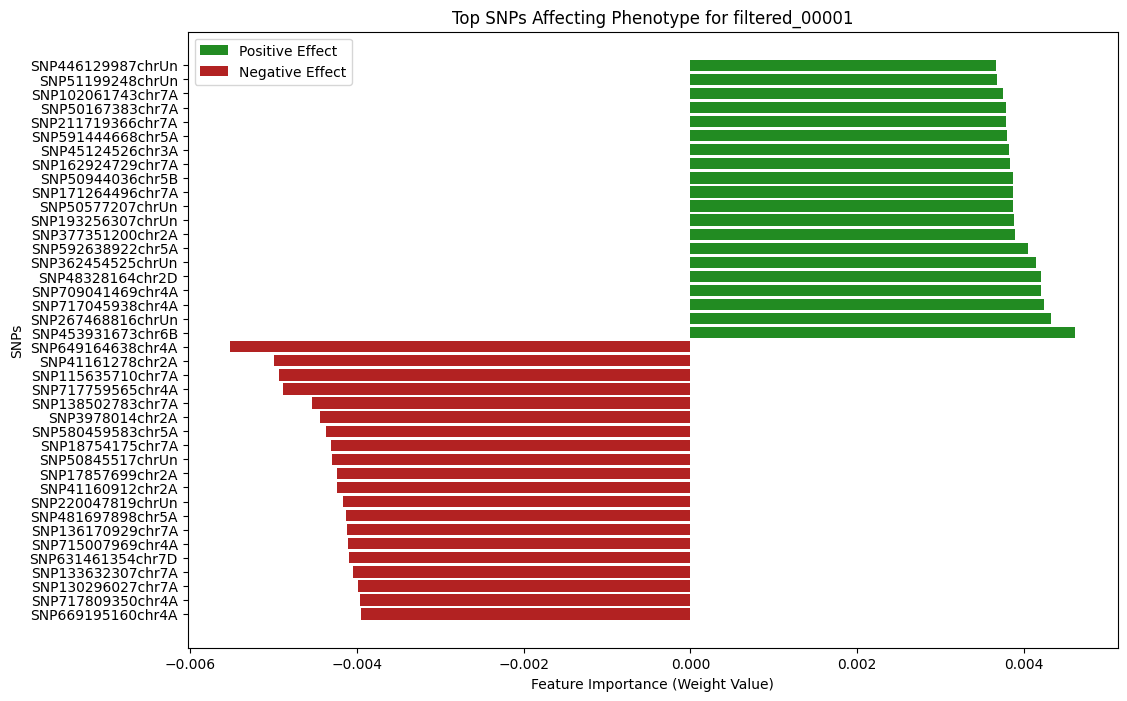

In [ ]:
PATH = "MLP_models/best_model_filtered_0001.pth"
input_length = get_SNP("filtered_0001.csv")[-1]
model0001 = createANNModel([16, 16, 8, 8], drop=0.3,lr=0.0001,decay=1e-5,input_length=input_length,activation_type="tanh",optimizer_type="sgd")[0]
model0001.load_state_dict(torch.load(PATH, map_location=device))  
model0001 = model0001.to(device) 
model0001.eval()
importance_graph(model00001, snp_number=20,data="filtered_00001")